---
title: A356 Lab 4 — Classification 
subtitle: Distinguishing Binary Star Systems
authors:
  - name: Earl Patrick Bellinger
    orcid: 0000-0003-4456-4863
    affiliations:
      - Department of Astronomy, Yale University
license: CC-BY-4.0
---

*tags*: `classification`, `random-forest`, `sklearn`, `ROC`, `eclipsing-binaries`, `ellipsoidal-variables`, `contact-binaries`, `data-visualization`

## Learning Goals 

In this lab, you will learn: 
1. Binary classification using machine learning 
2. Comparisons of the performances of classifiers 
3. Specificity, sensitivity, accuracy, confusion matrices, ROC curves 
4. How to distinguish binary star systems based on their photometric properties 

## Overview

Many stars belong to binary (and higher-order) systems. Nearly all massive stars have massive companions, and up to a third of them interact. Around 10% of solar-type stars may have a white dwarf companion! 

Many such systems are being observed by photometric surveys, such as the space-based NASA TESS mission, the ground-based OGLE observatory, and the forthcoming Rubin survey (formerly known as LSST). 

In this lab, we will be using the [OGLE-IV database of binary systems](https://ogledb.astrouw.edu.pl/~ogle/OCVS/ecl_query.php). I have downloaded the data for you; you can find it on canvas as `ogle_binaries.txt`. 

This data set contains a list of observed ellipsoidal and contact binary systems. We will be using machine learning to try to classify such stars based on their photometric properties. 

**Examples of ellipsoidal variables**
<p float="left">
  <img src="https://ogledb.astrouw.edu.pl/~ogle/OCVS/images/31/OGLE-LMC-ECL-07131_1.jpg" width=300 />
  <img src="https://ogledb.astrouw.edu.pl/~ogle/OCVS/images/13/OGLE-LMC-ECL-02713_1.jpg" width=300 />
  <img src="https://ogledb.astrouw.edu.pl/~ogle/OCVS/images/63/OGLE-LMC-ECL-05863_1.jpg" width=300 />
</p>

**Examples of contact binaries**
<p float="left">
  <img src="https://ogledb.astrouw.edu.pl/~ogle/OCVS/images/30/OGLE-LMC-ECL-04430_1.jpg" width=300 />
  <img src="https://ogledb.astrouw.edu.pl/~ogle/OCVS/images/59/OGLE-LMC-ECL-04559_1.jpg" width=300 />
  <img src="https://ogledb.astrouw.edu.pl/~ogle/OCVS/images/72/OGLE-LMC-ECL-01572_1.jpg" width=300 />
</p>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

np.random.seed(42) # for reproducibility 

In [2]:
# some statements to make the figures look nicer 
%config InlineBackend.figure_format='retina'
plt.rcParams.update({'axes.linewidth' : 1,
                     'ytick.major.width' : 1,
                     'ytick.minor.width' : 1,
                     'xtick.major.width' : 1,
                     'xtick.minor.width' : 1,
                     'xtick.labelsize': 10, 
                     'ytick.labelsize': 10,
                     'axes.labelsize': 12,
                     'font.family': 'Serif',
                     'figure.figsize': (10, 6)
                    })

:::{tip} Exercise 1

The data contain:
- the names of the binary systems
- their classification (contact `C` or ellipsoidal `ELL`)
- sky coordinates RA and Decl
- I- and V-band magnitudes and V-I color
- a period `P` estimated using a Box Least Squares periodogram
- two amplitude components `A_1` and `A_2`, obtained by fitting a statistical model to the light curve (see example light curves above)

1. Parse the supplied data. Inspect the columns so you know what you will be looking at, and information such as how many examples we have to work with. Note: it can be helpful to define a variable or an additional column in which the class labels (`C` or `ELL`) are represented by integers (0, 1) instead of strings. 
2. Plot the fitted amplitude components against the orbital period and against each other (see example plot below). Color the data points by their classification (i.e. contact or ellipsoidal binary). 
:::

In [3]:
## Your code here 

import pprint

df = pd.read_table('ogle_binaries.txt')
df

,ID,Type,RA,Decl,I,V,V_I,P,A_1,A_2
0,OGLE-LMC-ECL-00071,C,04:35:17.18,-69:41:44.8,13.569,14.574,1.005,0.350508,0.590,0.536
1,OGLE-LMC-ECL-00151,ELL,04:37:45.81,-69:33:30.1,18.841,18.961,0.120,0.990292,0.230,0.186
2,OGLE-LMC-ECL-00159,C,04:37:55.56,-70:35:13.2,17.539,18.741,1.202,21.970652,0.153,0.151
3,OGLE-LMC-ECL-00168,ELL,04:38:07.45,-67:54:31.4,15.847,17.203,1.356,204.123531,0.082,0.038
4,OGLE-LMC-ECL-00215,ELL,04:39:05.83,-68:37:23.6,18.219,19.271,1.052,69.267342,0.107,0.099
...,...,...,...,...,...,...,...,...,...,...
1606,OGLE-LMC-ECL-40197,ELL,06:21:31.88,-68:20:13.6,16.306,17.223,0.917,0.319619,0.072,0.050
1607,OGLE-LMC-ECL-40220,ELL,06:22:41.43,-67:49:32.7,15.230,16.840,1.610,152.753257,0.137,0.080
1608,OGLE-LMC-ECL-40245,C,06:24:45.79,-71:43:43.3,19.413,19.700,0.287,1.561936,0.289,0.285
1609,OGLE-LMC-ECL-40300,C,06:33:51.21,-70:59:24.1,15.646,17.050,1.404,0.215338,0.668,0.612


In [4]:
df['Type_num'] = df['Type'].map({'C':0, 'ELL':1}) # REMEMBER: C --> 0, ELL --> 1
df

,ID,Type,RA,Decl,I,V,V_I,P,A_1,A_2,Type_num
0,OGLE-LMC-ECL-00071,C,04:35:17.18,-69:41:44.8,13.569,14.574,1.005,0.350508,0.590,0.536,0
1,OGLE-LMC-ECL-00151,ELL,04:37:45.81,-69:33:30.1,18.841,18.961,0.120,0.990292,0.230,0.186,1
2,OGLE-LMC-ECL-00159,C,04:37:55.56,-70:35:13.2,17.539,18.741,1.202,21.970652,0.153,0.151,0
3,OGLE-LMC-ECL-00168,ELL,04:38:07.45,-67:54:31.4,15.847,17.203,1.356,204.123531,0.082,0.038,1
4,OGLE-LMC-ECL-00215,ELL,04:39:05.83,-68:37:23.6,18.219,19.271,1.052,69.267342,0.107,0.099,1
...,...,...,...,...,...,...,...,...,...,...,...
1606,OGLE-LMC-ECL-40197,ELL,06:21:31.88,-68:20:13.6,16.306,17.223,0.917,0.319619,0.072,0.050,1
1607,OGLE-LMC-ECL-40220,ELL,06:22:41.43,-67:49:32.7,15.230,16.840,1.610,152.753257,0.137,0.080,1
1608,OGLE-LMC-ECL-40245,C,06:24:45.79,-71:43:43.3,19.413,19.700,0.287,1.561936,0.289,0.285,0
1609,OGLE-LMC-ECL-40300,C,06:33:51.21,-70:59:24.1,15.646,17.050,1.404,0.215338,0.668,0.612,0


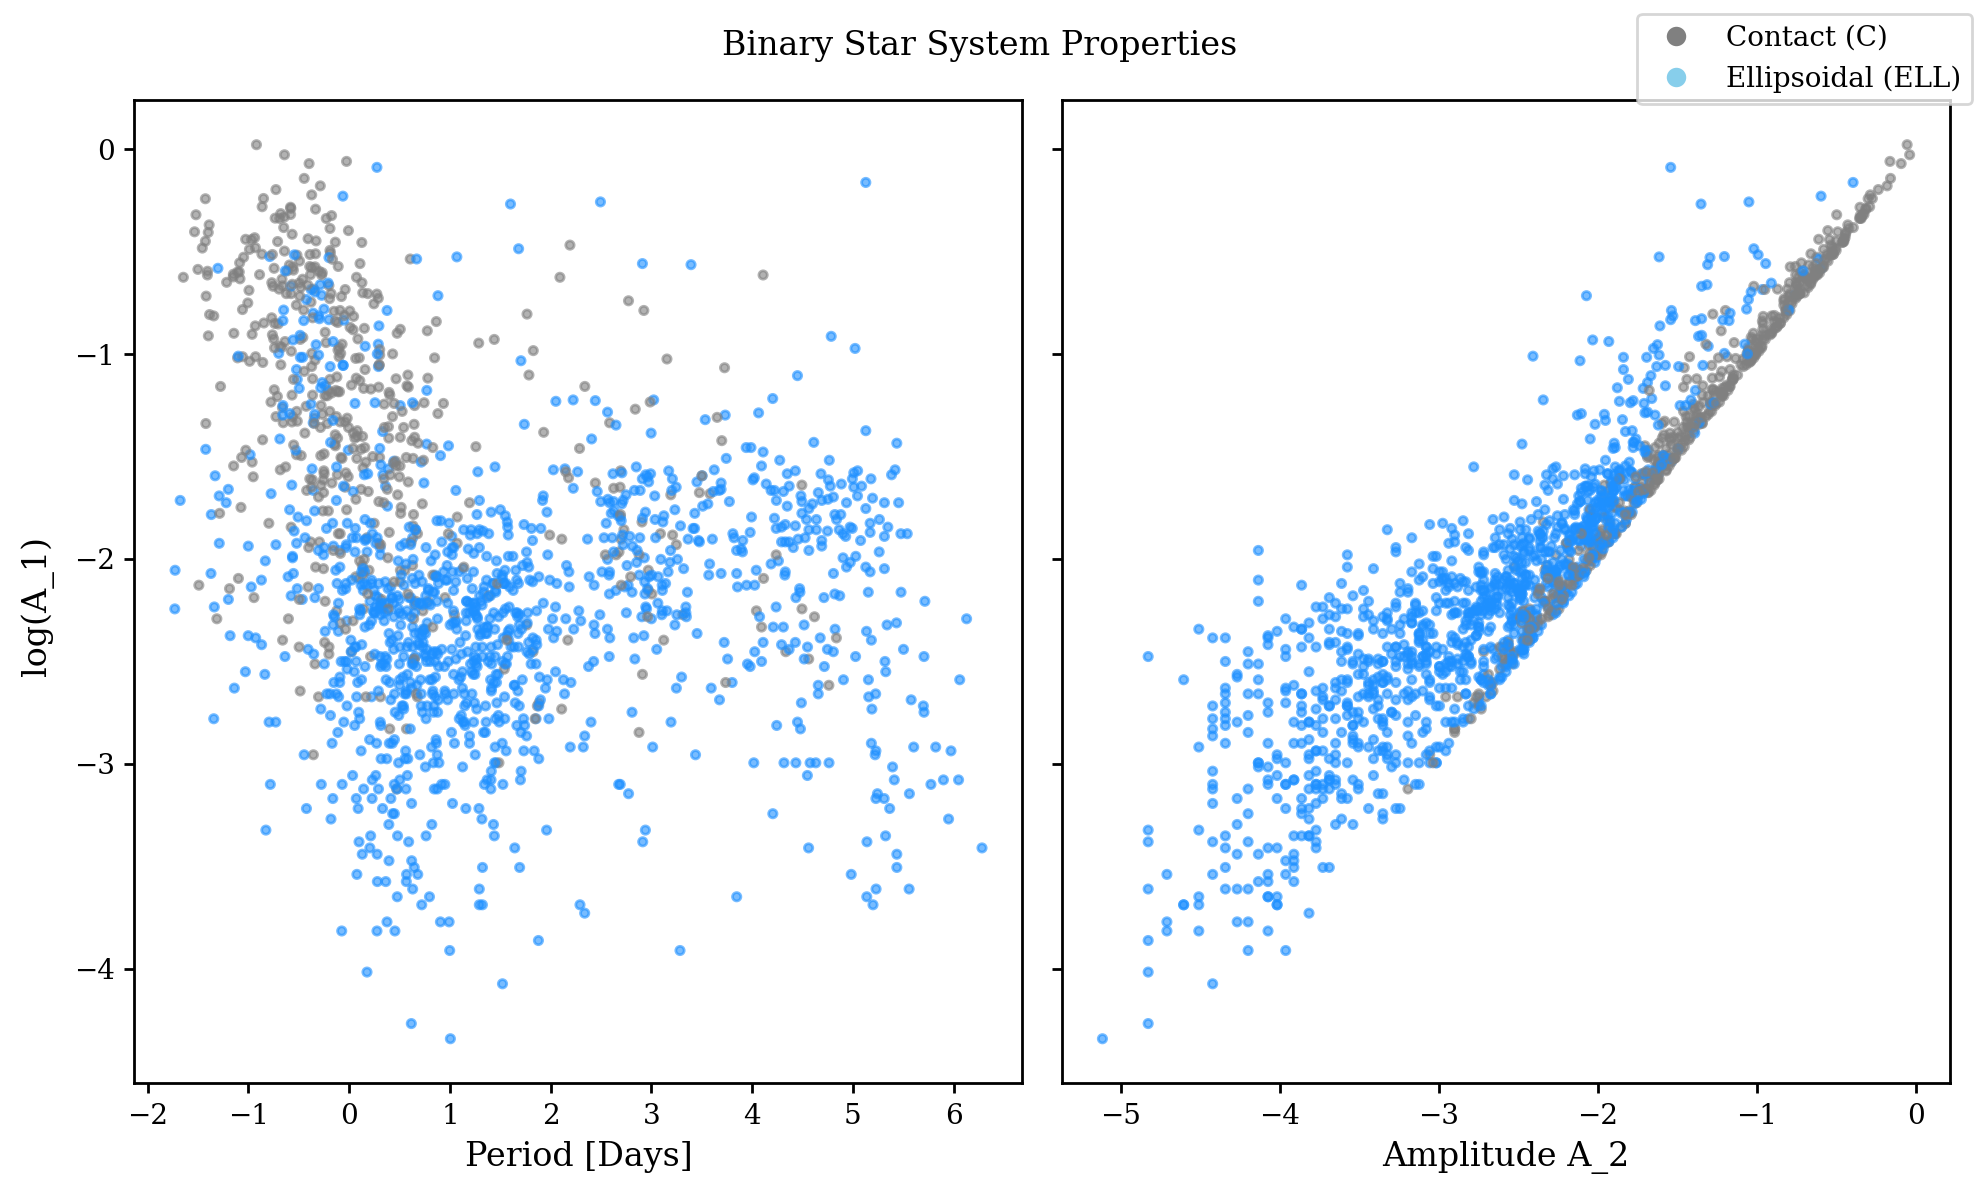

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6), sharey=True)

colormap = df['Type_num'].map({0:'grey', 1:'dodgerblue'})

axes[0].scatter(np.log(df['P']), np.log(df['A_1']), marker='.', c=colormap, alpha = 0.6)
axes[0].set_xlabel('Period [Days]')

axes[1].scatter(np.log(df['A_2']), np.log(df['A_1']), marker='.', c=colormap, alpha = 0.6)
axes[1].set_xlabel('Amplitude A_2')
#axes[1].legend()

fig.supylabel('log(A_1)')
fig.suptitle('Binary Star System Properties')

fig.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', label='Contact (C)',
                          markerfacecolor='grey', markersize=8),
                    plt.Line2D([0], [0], marker='o', color='w', label='Ellipsoidal (ELL)',
                          markerfacecolor='skyblue', markersize=8)])        # TODO: Try to redo the legend
                                                                            # This is the only way I could get labels to show up. 
                                                                            # There has to be a better way than doing it manually like this...

plt.tight_layout()
plt.show()

:::{tip} Exercise 2

We are now going to train a classifier to distinguish contact binaries from ellipsoidal variables. 

1. Split the data into a training set and a testing set using `train_test_split` from `sklearn`. The `X` variable contains the features and the `y` variable contains the classes. Think about it: what features should be included? Discard the features that you think would be irrelevant when classifying binary star systems. Stratify the train/test split using the `y` variable. 
3. Fit a RandomForestClassifier to the training data. 
4. Use the random forest to predict the labels of the test data. From this, compute the precision and recall for each of the classes. (*Hint*: `classification_report` in `sklearn.metrics`) 
:::

In [6]:
# Not using ID, RA, or Dec
feature_cols = ['V_I', 'P', 'A_1', 'A_2']
X = df[feature_cols].values
y = df['Type_num'].values

# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Fit a RandomForestClassifier
clf_rfc = RandomForestClassifier(random_state=42)
clf_rfc.fit(X_train, y_train)

# Predict the labels of the test data
y_pred = clf_rfc.predict(X_test)

# Compute precision and recall for each class
from sklearn.metrics import classification_report
#print(classification_report(y_test, y_pred)) # Used to see which one was contact and which was ellipsoidal
print(classification_report(y_test, y_pred, target_names=['Contact (C)', 'Ellipsoidal (ELL)']))

                   precision    recall  f1-score   support

      Contact (C)       0.84      0.78      0.81       144
Ellipsoidal (ELL)       0.91      0.94      0.92       340

         accuracy                           0.89       484
        macro avg       0.87      0.86      0.87       484
     weighted avg       0.89      0.89      0.89       484



:::{tip} Exercise 3

Plot a confusion matrix. (*Hint*: `confusion_matrix` in `sklearn.metrics`)

Suppose you apply this classifier to some unseen data. It tells you the star is a contact binary. How confident are you that it is right? Suppose it says ellipsoidal: how confident are you that it is right? 
:::

In [7]:
cm = confusion_matrix(y_test, y_pred, normalize='true') # The normalize part makes it go from 0 to 1
cm

array([[0.78472222, 0.21527778],
       [0.06470588, 0.93529412]])

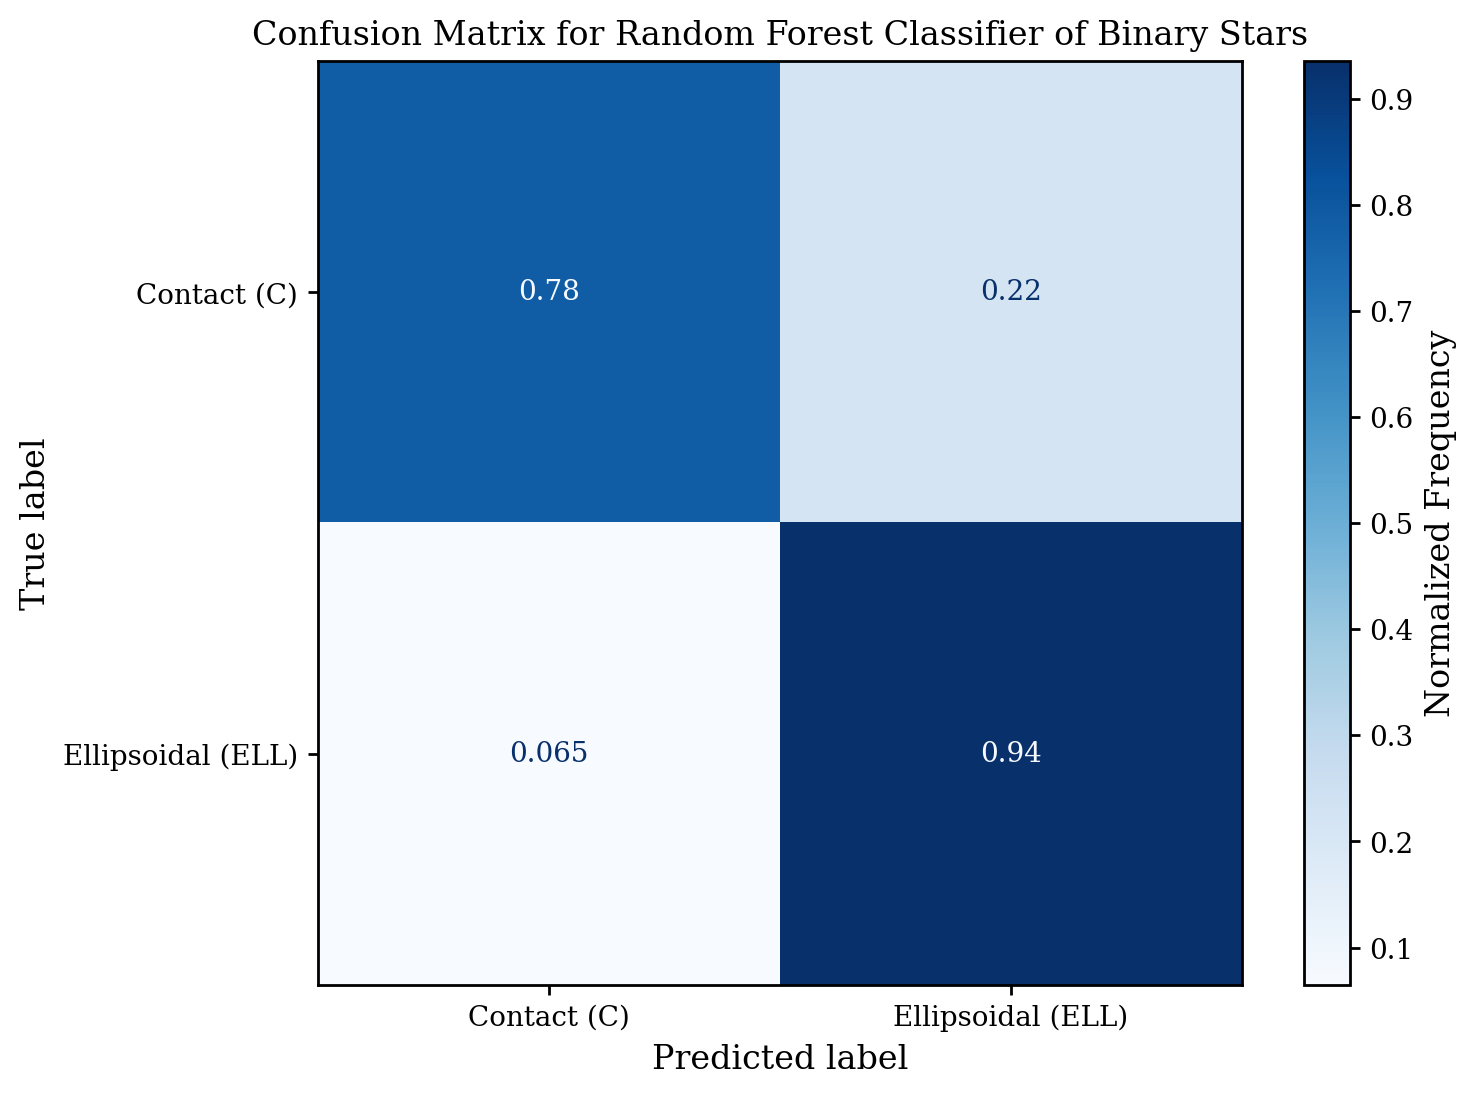

In [8]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(8, 6)) # IMPORTANT: Learn to do this more, as it gives me more flexibility to modify the plot


display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Contact (C)', 'Ellipsoidal (ELL)'])
im = display.plot(ax=ax, cmap=plt.cm.Blues, colorbar=False)  # Disable default colorbar, also ConfusionMatrixDisplay acts weirdly, it has its own plotting features
plt.title('Confusion Matrix for Random Forest Classifier of Binary Stars')
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Add a single colorbar with label
cbar = fig.colorbar(ax.images[0], ax=ax)
cbar.set_label('Normalized Frequency')

plt.show()

### Written Part:



If it predicted it was a contact, I'm 78% sure it actually is a contact. If it predicted ellipsoidal, I'm 94% sure it actually is ellipsoidal.

:::{tip} Exercise 4

Scikit-learn has many classification algorithms in addition to random forests, including logistic regression, k-nearest neighbors, and support vector machines. 

Import each of these, fit them to the training data in a loop, and use `RocCurveDisplay` to compare their performances on the test data. Write a short description of the results. 

We didn't adjust any of the free parameters of any of the classifiers. Look up the free parameters of these four algorithms and write a short description of how they affect the classifier. Lastly, write down how we could determine good values for these free parameters. 

Note: please write your own answers for written components (i.e. no generative AI for text - I prefer it's used only for code). 
:::

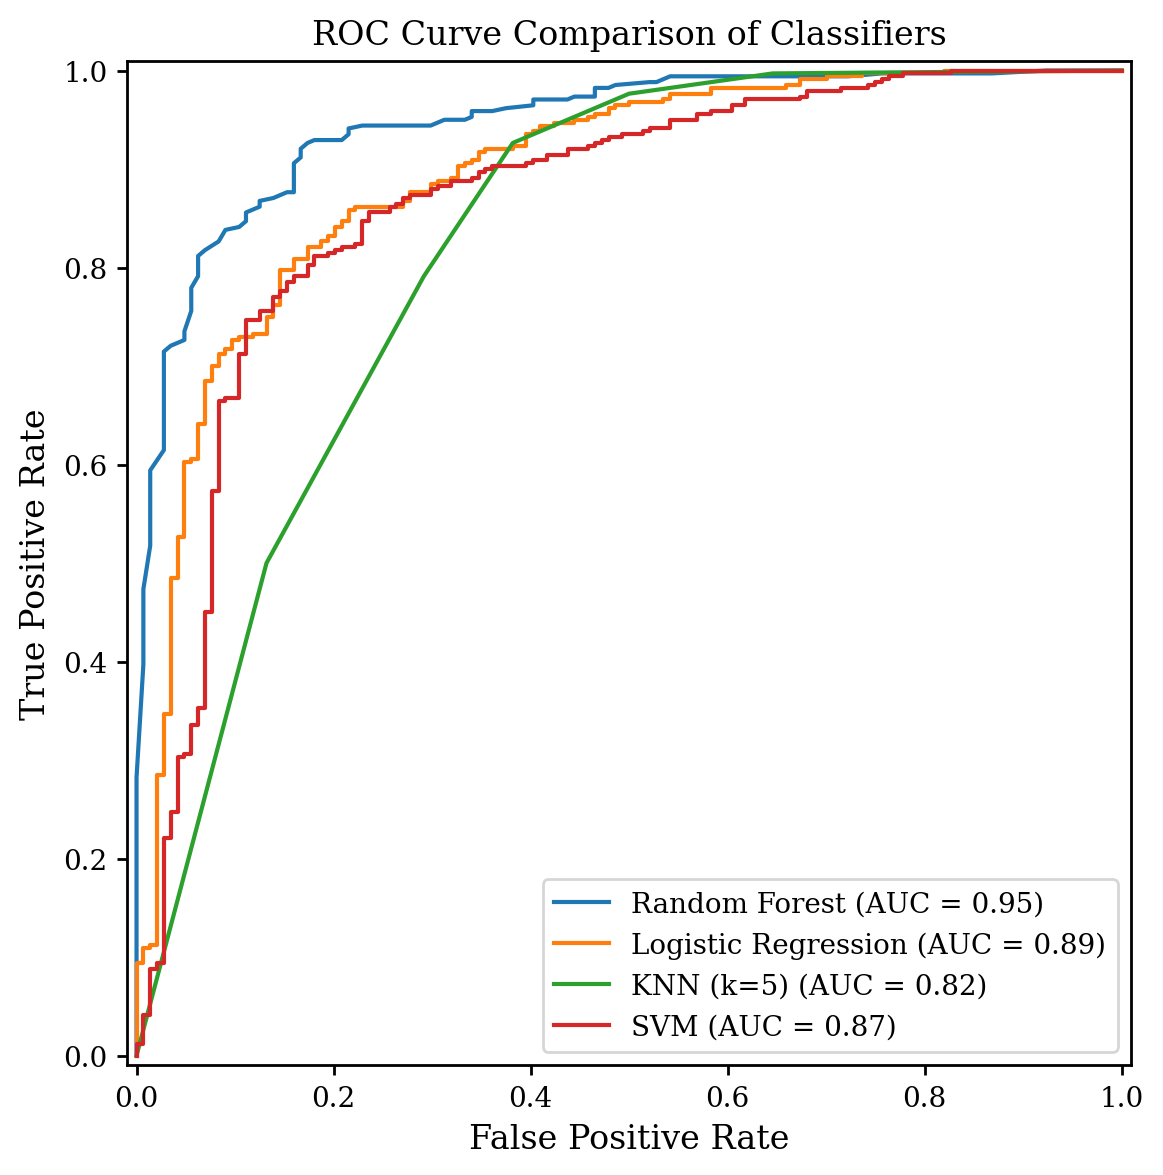

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import RocCurveDisplay

# Define classifiers
classifiers = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42),
    'KNN (k=5)': KNeighborsClassifier(),
    'SVM': SVC(random_state=42)
}

fig, ax = plt.subplots()

for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    if hasattr(clf, "predict_proba"):
        y_score = clf.predict_proba(X_test)[:, 1]
    else:
        # For classifiers without predict_proba (e.g., SVM with probability=False)
        y_score = clf.decision_function(X_test)
    RocCurveDisplay.from_predictions(y_test, y_score, name=name, ax=ax)

plt.title('ROC Curve Comparison of Classifiers')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.tight_layout()
plt.show()

In [10]:
# TODO: Look below for future reference when looking for parameter information

### Written Part

**1) Random Forest**
[Docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
- `n_estimators`: Number of trees in the forest. More trees can improve performance but increase computation time.
- `max_depth`: Maximum depth of each tree. Controls model complexity. Deeper trees can overfit.
- `min_samples_split`: Minimum samples required to split a node. Higher values make model simpler

**2) Logistic Regression**
[Docs](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
- `penalty`: Type of regularization (`l1`, `l2`, `elasticnet`, or `none`). helps prevent overfitting
- `C`: Inverse of regularization strength. Smaller values -> stronger regularization.
- `solver`: Algorithm to use for optimization

**3) KNN**
[Docs](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
- `n_neighbors`: Number of neighbors to use. Low values can overfit, high values can underfit.
- `weights`: How to weigh the contribution of neighbors (`uniform`, `distance`).
- `metric`: Distance metric used (`minkowski`).
 
**4) SVM**
[Docs (Specifically, SVC)](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC)
- `C`: Regularization parameter. Higher values mean less regularization (can overfit), lower values increase regularization (can underfit).
- `kernel`: Specifies the kernel type (`linear`, `rbf`, `poly`)
- `gamma`: Kernel coefficient for `rbf`, `poly`, and `sigmoid`



**How to Determine Good Values:**
[Docs](https://scikit-learn.org/stable/modules/cross_validation.html)
- Use cross-validation (like `GridSearchCV` or `RandomizedSearchCV`) to test combinations of parameter values and select tge ones that give the best performance on validation data.
- Visualize performance (like ROC plot above) as a function of parameter values

:::{tip} Exercise 5

Random forests have a degree of interpretability through their feature importances. Plot the feature importances of your fitted random forest model. What is the most important feature when distinguishing ellipsoidal variables from contact binaries? Why do you think it is that one? 
:::

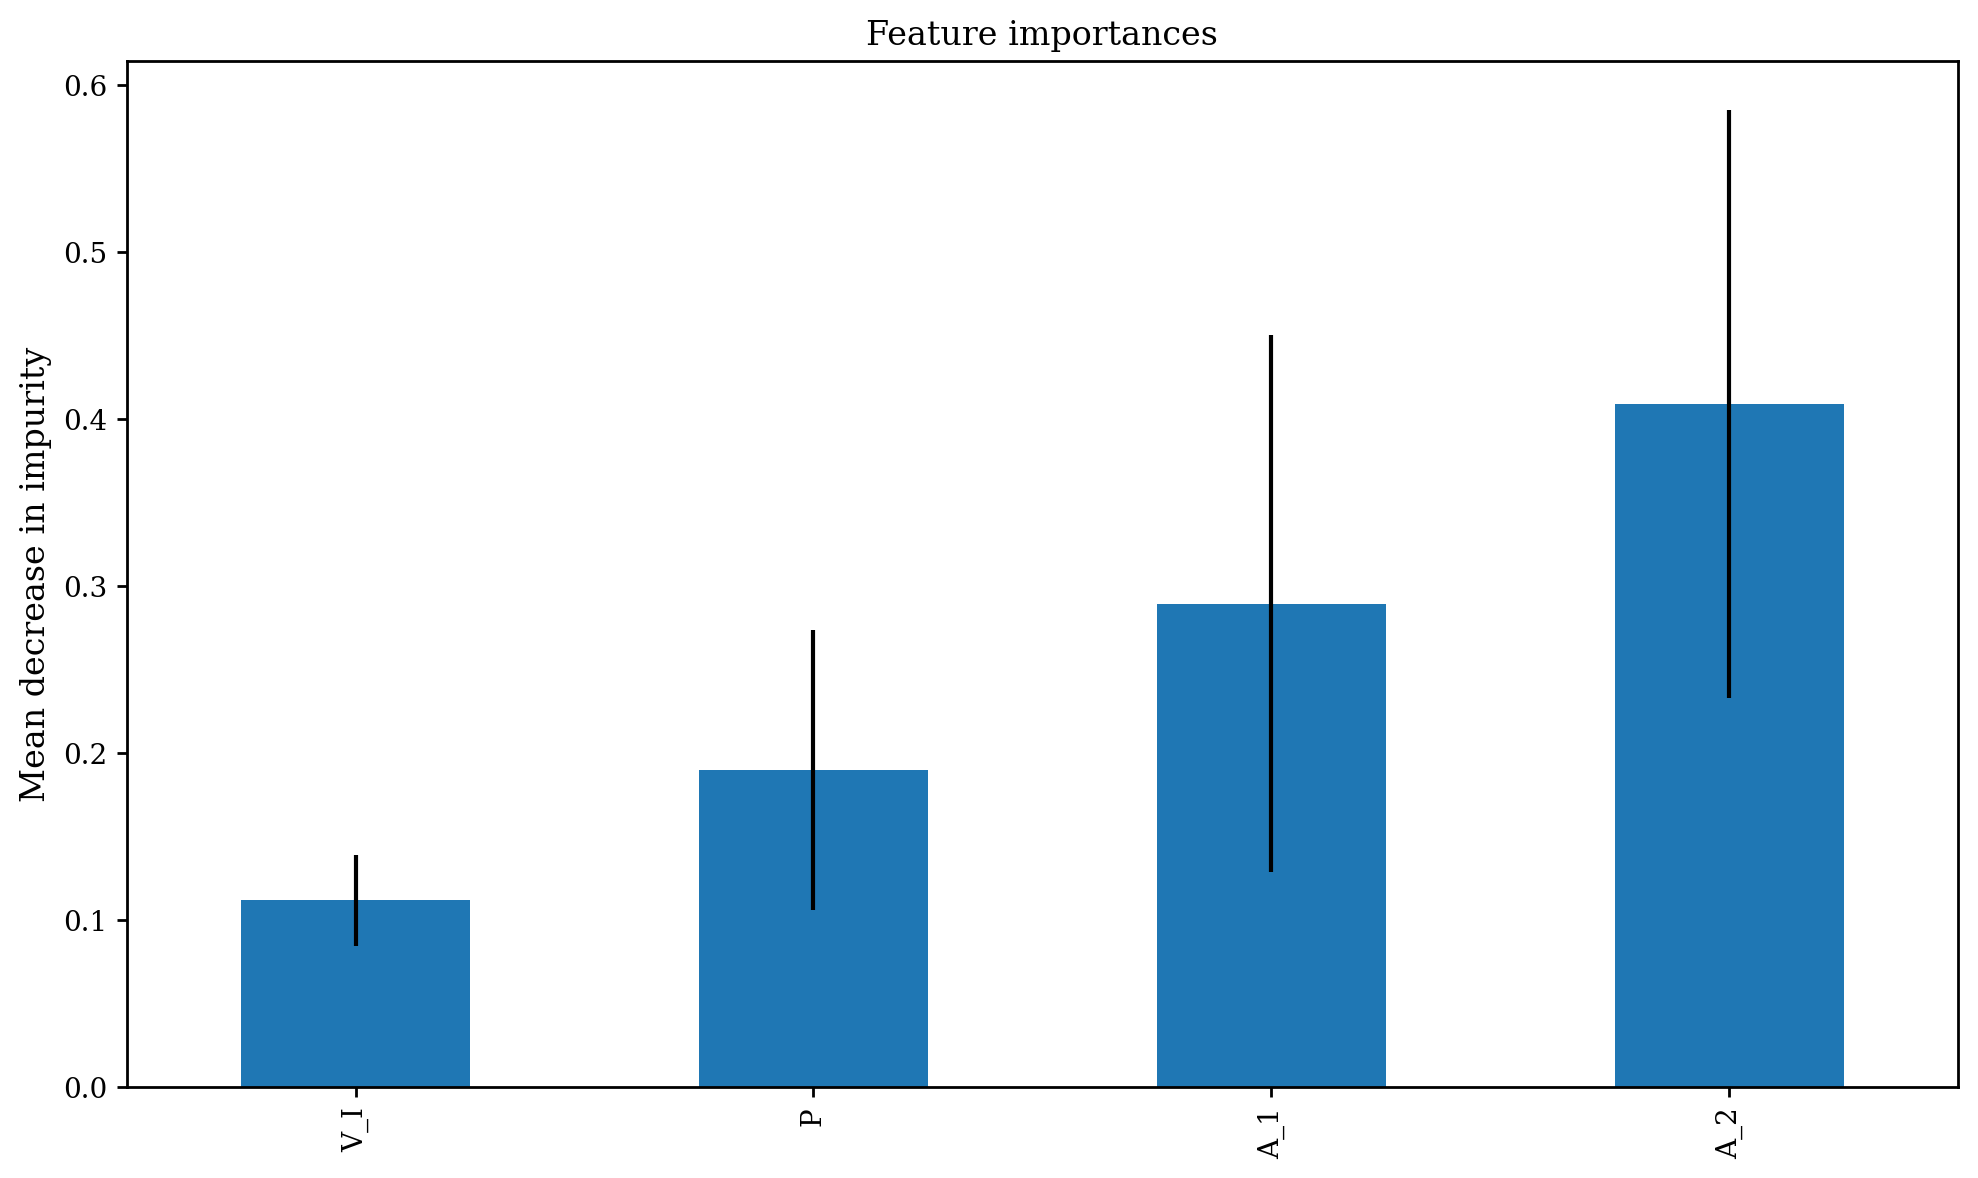

In [11]:
## Your code here 

# Docs: https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

importances = clf_rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_rfc.estimators_], axis=0)

forest_importances = pd.Series(importances, index=feature_cols)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

### Written Part

It looks like the secondary amplitude is the most important feature. As is shown in the slides from class (specifically the graph of the different examples), contact binaries have very pronounced secondary amplitudes, while ellipsoidal binaries have weak secondary amplitudes. This is a key distinction between the two, and it can be used to classify into each of the types.

:::{tip} Bonus Problem 1 

Download the photometry for one or more of the binaries in the OGLE database (linked in the introduction to this lab). Plot a Box Least Squares periodogram (available in astropy) and a phased light curve. Compare it with a Lomb-Scargle periodogram. 
:::

# Ignore the EC, I didn't get it to work, I'll attempt it another day

### [Knowns, taken from OGLE](https://ogledb.astrouw.edu.pl/~ogle/OCVS/getobj.php?s=OGLE-LMC-ECL-00001&q=EL6nD1IH0lhRU0z32UADYEyETNUr3CJg1rtw4t64HisS0Ffhb_S76tYGsdc_NO1EgABFXdyaH8wEJmdUAC_fRSuIGKPbw9CEpp6_8iayf5XS8klESZMRFMYFhk.o2q5OhvZTAuTBWvBkGmvAv3bc8Sa6ulg-&pos=BigYo1AJM8PXxOI.3BrFIOQqlNKE9dSyvrBKXFxuaTLPdlFr._mEIEoek78DBxiWjOZmo8bJZLpHOEf1aeKSFOgEWPbKiJ5MA45GXD3xCZjHx16V)

I = 18.681 mag

V = 19.613 mag

V-I = 0.932 mag

P = 7.3467222 d

T0 = 7003.4405 d

A_1 = 0.291 mag

A_2 = 0.255 mag

In [12]:
## Your bonus code here 

df = pd.read_table('OGLE-LMC-ECL-00001.dat', names = ['HJD-2450000', 'mag', 'err'], delimiter='\s+')
df


,HJD-2450000,mag,err
0,5262.50650,18.921,0.054
1,5264.50830,18.718,0.035
2,5265.59327,18.834,0.051
3,5266.50460,18.863,0.054
4,5267.50409,18.709,0.047
...,...,...,...
317,6700.64917,18.576,0.032
318,6704.67931,18.704,0.053
319,6709.52987,18.955,0.035
320,6713.59339,18.687,0.036


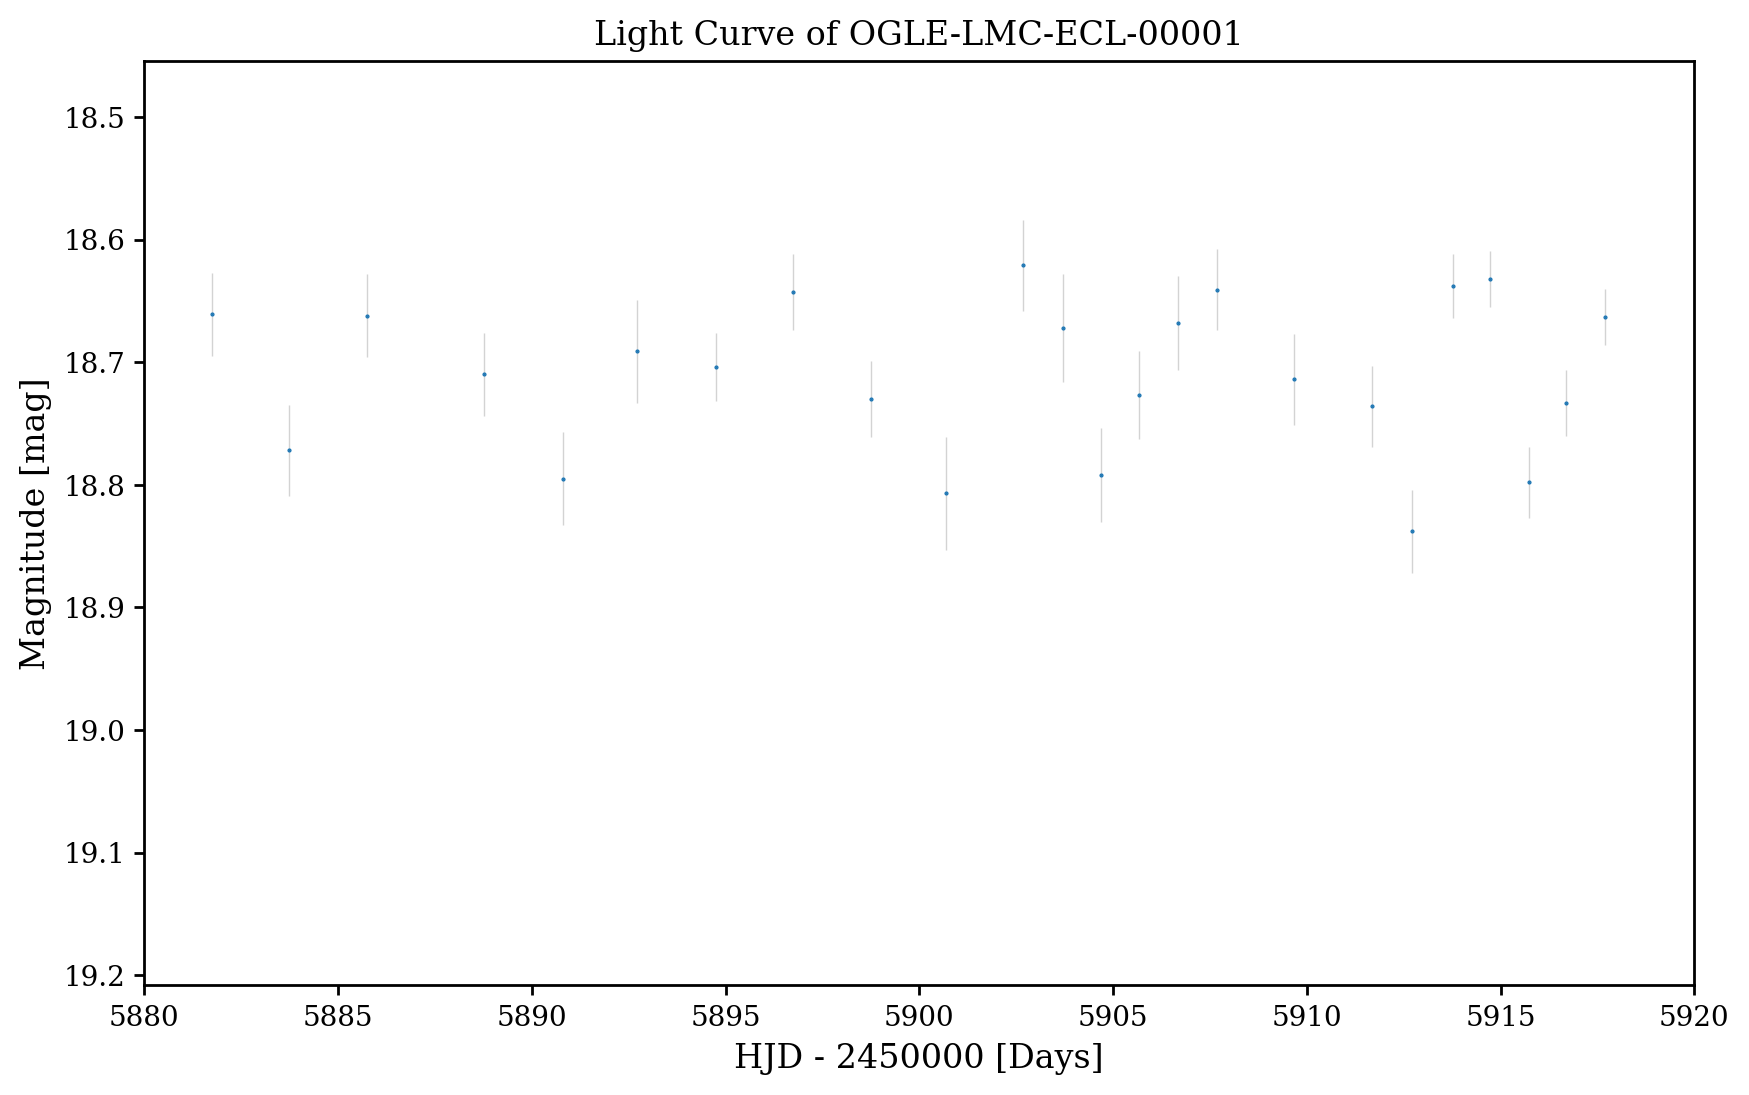

In [13]:
plt.errorbar(df['HJD-2450000'], df['mag'], yerr=df['err'], fmt='.', markersize=1, ecolor='lightgray', elinewidth=0.5)
plt.gca().invert_yaxis()  # Magnitude axis is typically inverted in astronomy
plt.xlabel('HJD - 2450000 [Days]')
plt.xlim(5880,5920)
plt.ylabel('Magnitude [mag]')
plt.title('Light Curve of OGLE-LMC-ECL-00001')
plt.show()

In [14]:
import astropy.units as u
from astropy.timeseries import BoxLeastSquares

## Docs: https://docs.astropy.org/en/stable/timeseries/bls.html

t = df['HJD-2450000'].values
y = df['mag'].values
dy = df['err'].values

In [22]:
def phase_plot(time, period, mag, yerr):

    time = np.mod(time/period, 2)

    plt.errorbar(time, mag, yerr, color = 'black', fmt='none', linewidth = 1,capsize=1, label='Data with error bars')
    plt.gca().invert_yaxis()
    plt.xlabel('Phase')
    plt.ylabel('i-band Magnitude')
    plt.title('Anomalous Cepheid Light Curve')
    plt.legend()
    plt.tight_layout()

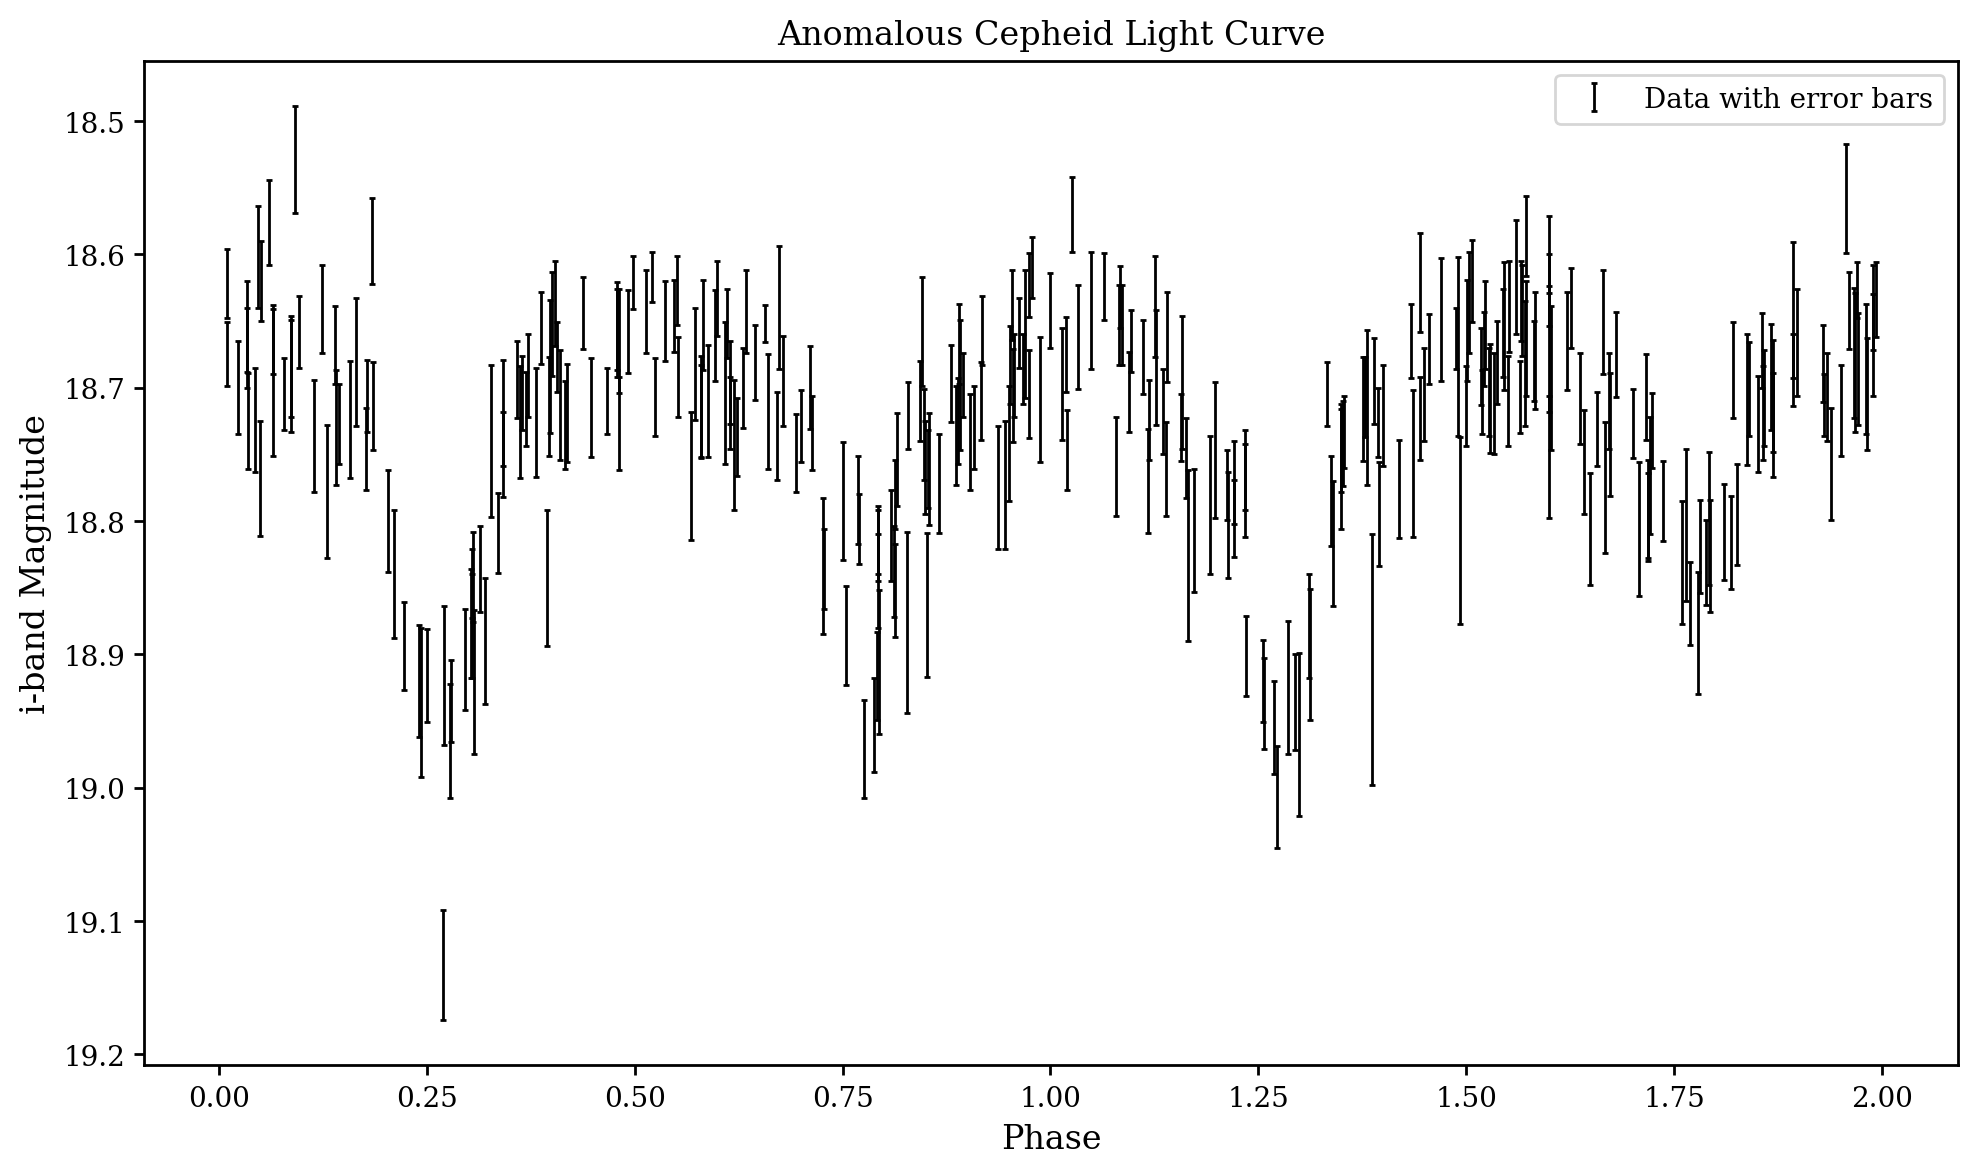

In [23]:
phase_plot(t, 7.3467222, y, dy) # Period from OGLE website

In [31]:
run = True
if run:
    model = BoxLeastSquares(t, y, dy)
    periodogram = model.autopower(0.2)

(0.0, 10.0)

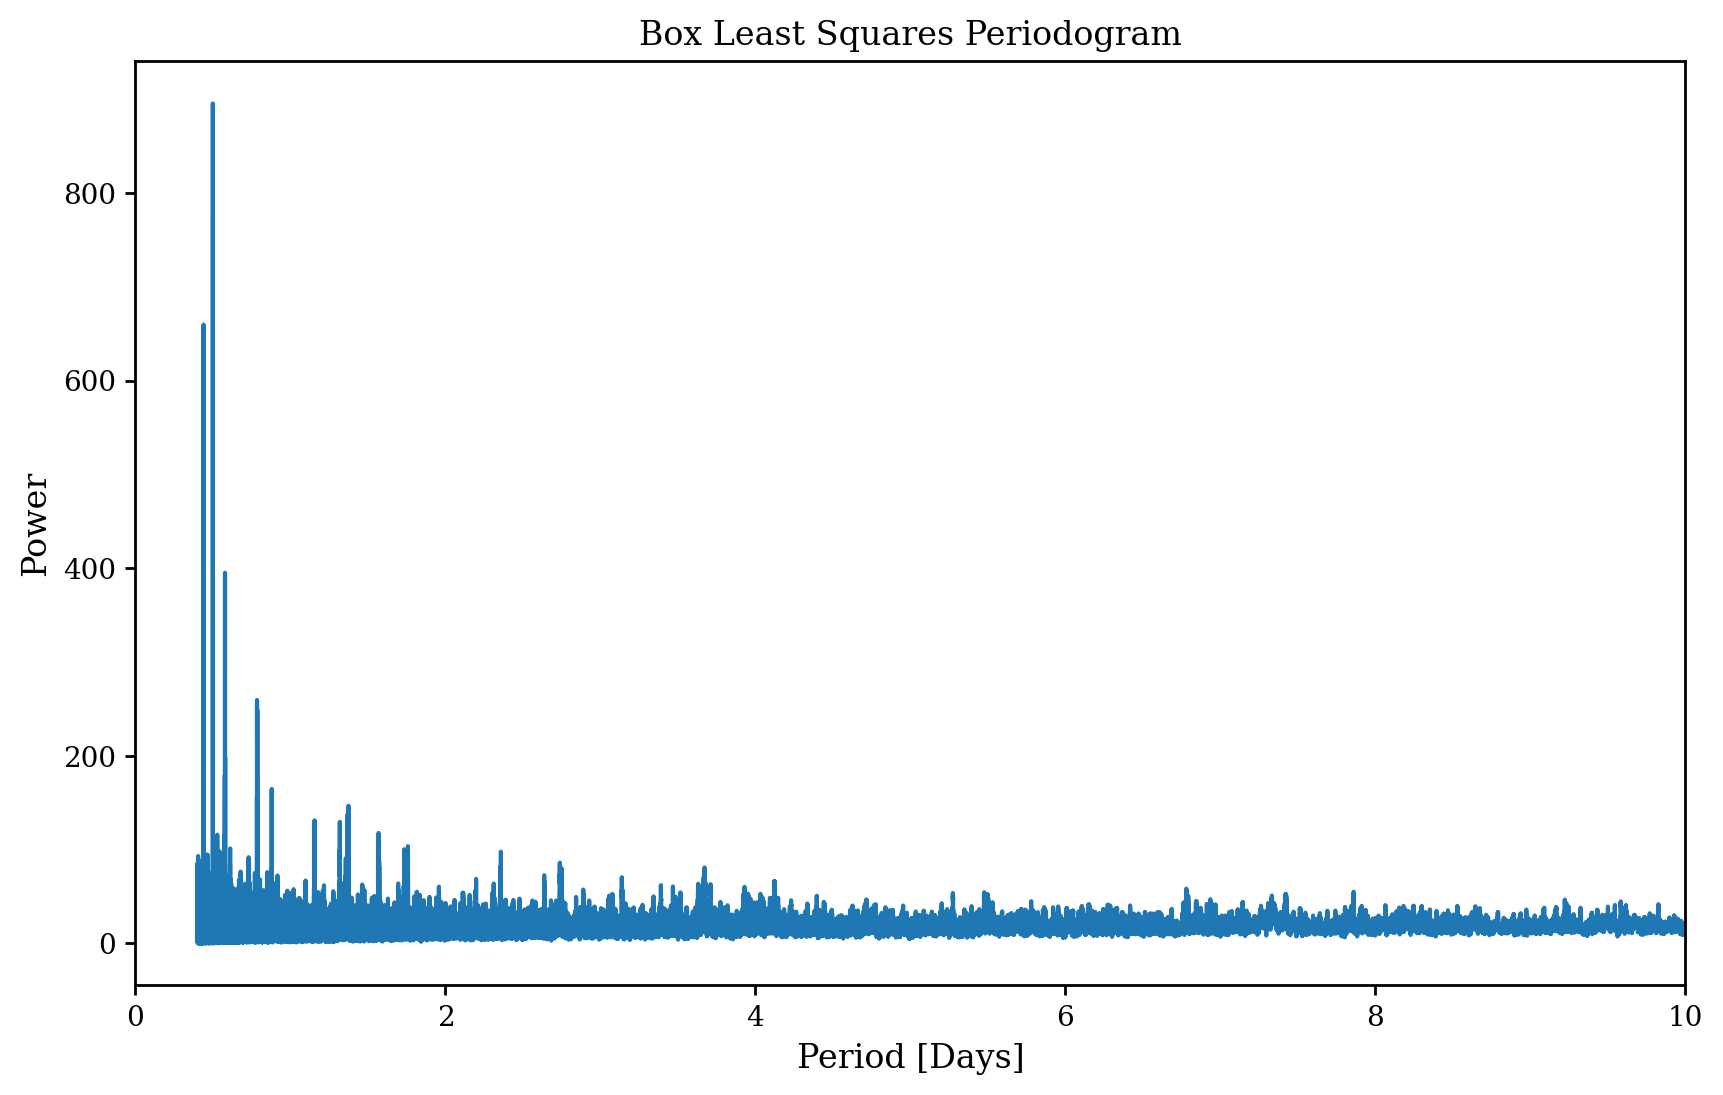

In [32]:
fig, ax = plt.subplots()

ax.plot(periodogram.period, periodogram.power)

ax.set_xlabel('Period [Days]')
ax.set_ylabel('Power')
ax.set_title('Box Least Squares Periodogram')

ax.set_xlim(0, 10)

In [33]:
from astropy.timeseries import LombScargle

frequency, power = LombScargle(t, y, dy).autopower(nyquist_factor=3000) # I increased the nyquist_factor until I saw period values for near 0 days

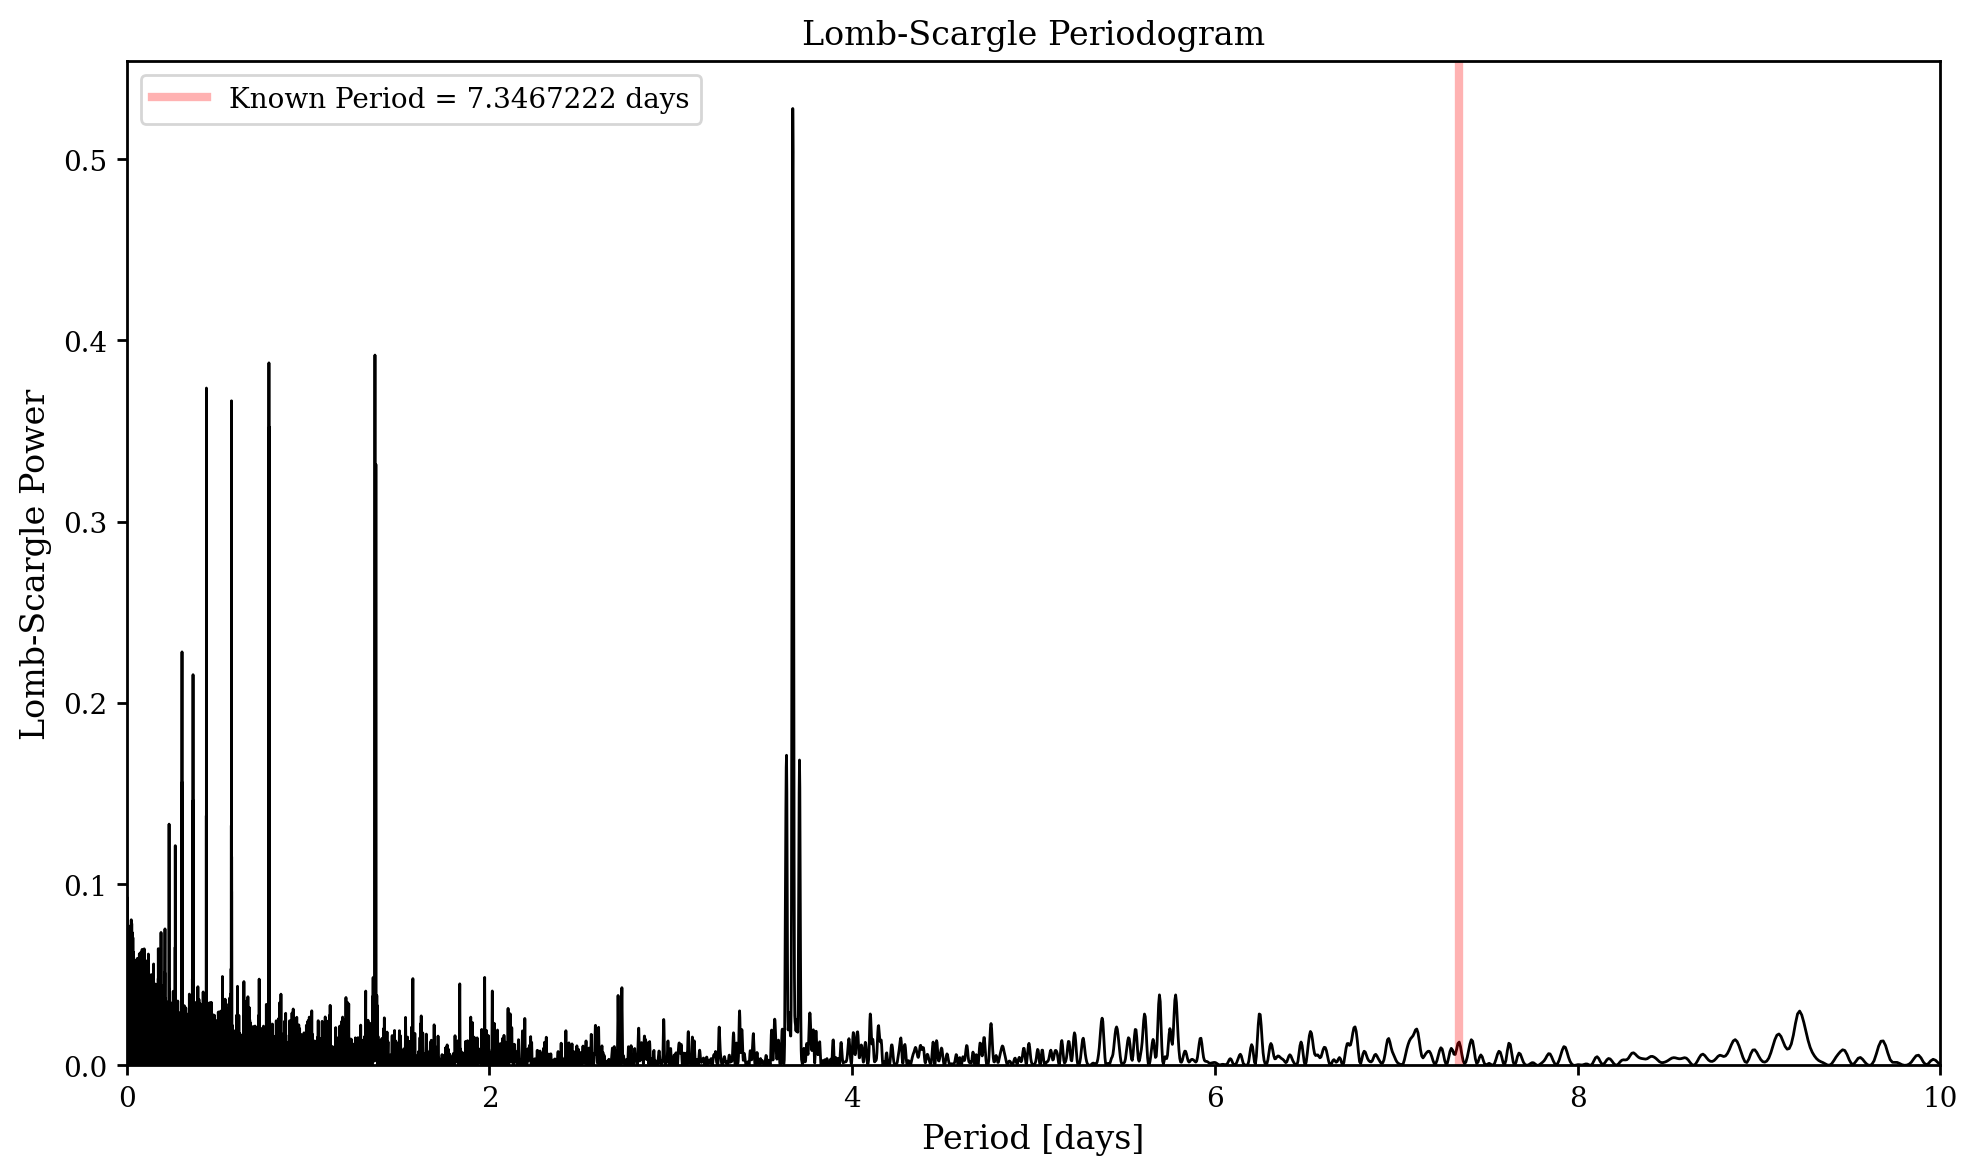

In [34]:
plt.plot(1/frequency, power, color = 'black', linewidth=1)

plt.axvline(7.3467222, color='red', linewidth = 3, alpha = 0.3, label='Known Period = 7.3467222 days')

plt.xlabel('Period [days]')
plt.ylabel('Lomb-Scargle Power')
plt.ylim(bottom = 0)
plt.title('Lomb-Scargle Periodogram')
plt.legend()
plt.xlim(0,10)
plt.tight_layout()

:::{tip} Bonus Problem 2 

Download the photometry for one or more of the binaries in the OGLE database. Fit a statistical model of your choosing or design to the light curve. You can take inspiration from how we fit the light curve of a Cepheid, though you may wish to opt for a different model more appropriate for binaries. 
:::

In [ ]:
## Your bonus code here 



:::{tip} Bonus Problem 3 

Download the photometry for a large number of binaries in the OGLE database. Fit a statistical model to their light curves, and make a table of the fitted parameters. Use the fitted parameters as features to train a classifier. Can you make better features than `A_1` and `A_2` from OGLE? 
:::

In [ ]:
## Your bonus code here 



:::{tip} Bonus Problem 4 

Train a neural network to classify binaries based on their light curves. For example, you could classify binary stars using computer vision by training a convolutional neural network on images of their light curves. You could use one of the image classification notebooks [here](https://flax.readthedocs.io/en/latest/examples/core_examples.html) as a starting point. 
:::

In [ ]:
## Your bonus code here 



ChatGPT link: 